In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (24, 16)
import seaborn as sns
import datetime
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

## Functions

In [2]:
def import_files(path):
    file_dfs = {}
    for subject_type in os.listdir(path):
        for subject_ID in os.listdir(f"{path}/{subject_type}"):
            df = pd.read_csv(f"{path}/{subject_type}/{subject_ID}/glucose.csv")
            join_date_time(df, "date", "time")
            df.index = pd.to_datetime(df.datetime)
            df.drop(columns=["type","comments","datetime"],inplace=True)
            file_dfs[f"{subject_type}_{subject_ID}"] = df

    return file_dfs

In [3]:
def join_date_time(df, date_col, time_col):
    new_df = pd.to_datetime(df[date_col].astype(str) + ' ' +df[time_col].astype(str))
    df.insert(2, 'datetime', new_df)
    df.drop(columns=[date_col, time_col],inplace=True)    

In [4]:
def fix_index(index_df, df):
    return index_df.join(df.resample("H").mean())

In [5]:
def find_stats(my_dict, df, resample_period, target, n, i, day):
    my_dict["subjectID"].append([i]*n)
    
    my_dict["mean"].append(df.resample(resample_period).mean().values)
    my_dict["min"].append(df.resample(resample_period).min().values)
    my_dict["max"].append(df.resample(resample_period).max().values)
    my_dict["std"].append(df.resample(resample_period).std().values)
    my_dict["target"].append([target]*n)
    my_dict["day"].append(day)

In [6]:
def train_test_split(X):
    X.dropna(thresh=5, inplace=True)
    X_train = X[(X["day"] != 4) & (X["subjectID"] != 10)].drop(columns=["target","subjectID","day"]).reset_index(drop=True)
    y_train = X[(X["day"] != 4) & (X["subjectID"] != 10)][["target"]].reset_index(drop=True)

    X_test = X[(X["day"] == 4) | (X["subjectID"] == 10)].drop(columns=["target","subjectID","day"]).reset_index(drop=True)
    y_test = X[(X["day"] == 4) | (X["subjectID"] == 10)][["target"]].reset_index(drop=True)
    
    return X_train, y_train, X_test, y_test 

## Import data

As mentioned in the initial analysis there is one subject who has diabetes but for the purpose of the dataset was treated as a "healthy" subject.

For this reason I will exclude this subject from the training but will use in the testing stage of this file.

In [7]:
glucose_dfs = import_files("data/processed_data")

glucose_dfs["healthy_subset_017"].iloc[17] = glucose_dfs["healthy_subset_017"].iloc[17].values[0].replace(":",".")
glucose_dfs["healthy_subset_017"] = glucose_dfs["healthy_subset_017"].astype("float")

test_subject = glucose_dfs.pop("healthy_subset_012_diabetes")

## Data Processing

I will take the raw glucose data and apply feature engering to create the following features for each day.

1. Mean
2. Min
3. Max
4. Range
5. Standard deviation
6. Target, [0,1] = [Diabetes, Healthy]

In [8]:
# Find the number of times healthy subjects checked their glucose.
for key in glucose_dfs.keys():
    if key.split("_")[0] == "healthy":
        print(len(glucose_dfs[key]))

24
24
31
24
24


Since subjects measured their glucose at differnet times in the day I will resample the data and   
as most healthy subjects measured their glucose 24 times over the 4 days I will resample to 6 (24/4) hour periods.

In [9]:
resample_freq = "6H"
indx = pd.date_range("2014-10-01","2014-10-05", freq=resample_freq)
resampled_glucose = pd.DataFrame(index=indx)

In [10]:
index_df = pd.DataFrame(index=pd.date_range("2014-10-01","2014-10-05", freq="H"))
print("Date range of most of the subjects")
print(set([day.date() for day in index_df.index[:-1]]), end="\n\n")
print("Date range of the test subject")
print(set([day.date() for day in test_subject.index]))

Date range of most of the subjects
{datetime.date(2014, 10, 1), datetime.date(2014, 10, 2), datetime.date(2014, 10, 3), datetime.date(2014, 10, 4)}

Date range of the test subject
{datetime.date(2014, 9, 30), datetime.date(2014, 10, 1), datetime.date(2014, 10, 2), datetime.date(2014, 10, 3)}


It seems that the test subject started measuring their glucose one day earlier than the rest.
As I don't believe the specific dates have a major impact on the outcome I will adjust the test subjects dates to fit with the rest.

In [11]:
test_subject.index += datetime.timedelta(days=1)

In [12]:
stat_dict = {"subjectID":[],
             "day":[],
            "mean":[],
             "min":[],
             "max":[],
             "std":[],
             "target":[],
            }
#This df is used to fix all dfs lengths.
index_df = pd.DataFrame(index=pd.date_range("2014-10-01","2014-10-05", freq="H"))
indxLen = len(resampled_glucose)
resample_freq = "6H"
day = [day.day for day in pd.date_range("2014-10-01","2014-10-05", freq=resample_freq)]
for i, key in enumerate(glucose_dfs.keys()):
    
    df = glucose_dfs[key]
    df = fix_index(index_df, df)
    
    target = 1 if key.split("_")[0] == "diabetes" else 0
    find_stats(stat_dict, df, resample_freq, target, indxLen, i, day)

df = test_subject
df = fix_index(index_df, df)
find_stats(stat_dict, df, resample_freq, 1, indxLen, 10, day)

for key in stat_dict:
    stat_dict[key] = np.array(stat_dict[key]).reshape(-1)
    
stat_dict["range"] = stat_dict["max"]-stat_dict["min"]

stat_df = pd.DataFrame(stat_dict)

In [13]:
for key in stat_dict:
    print(len(stat_dict[key]))

187
187
187
187
187
187
187
187


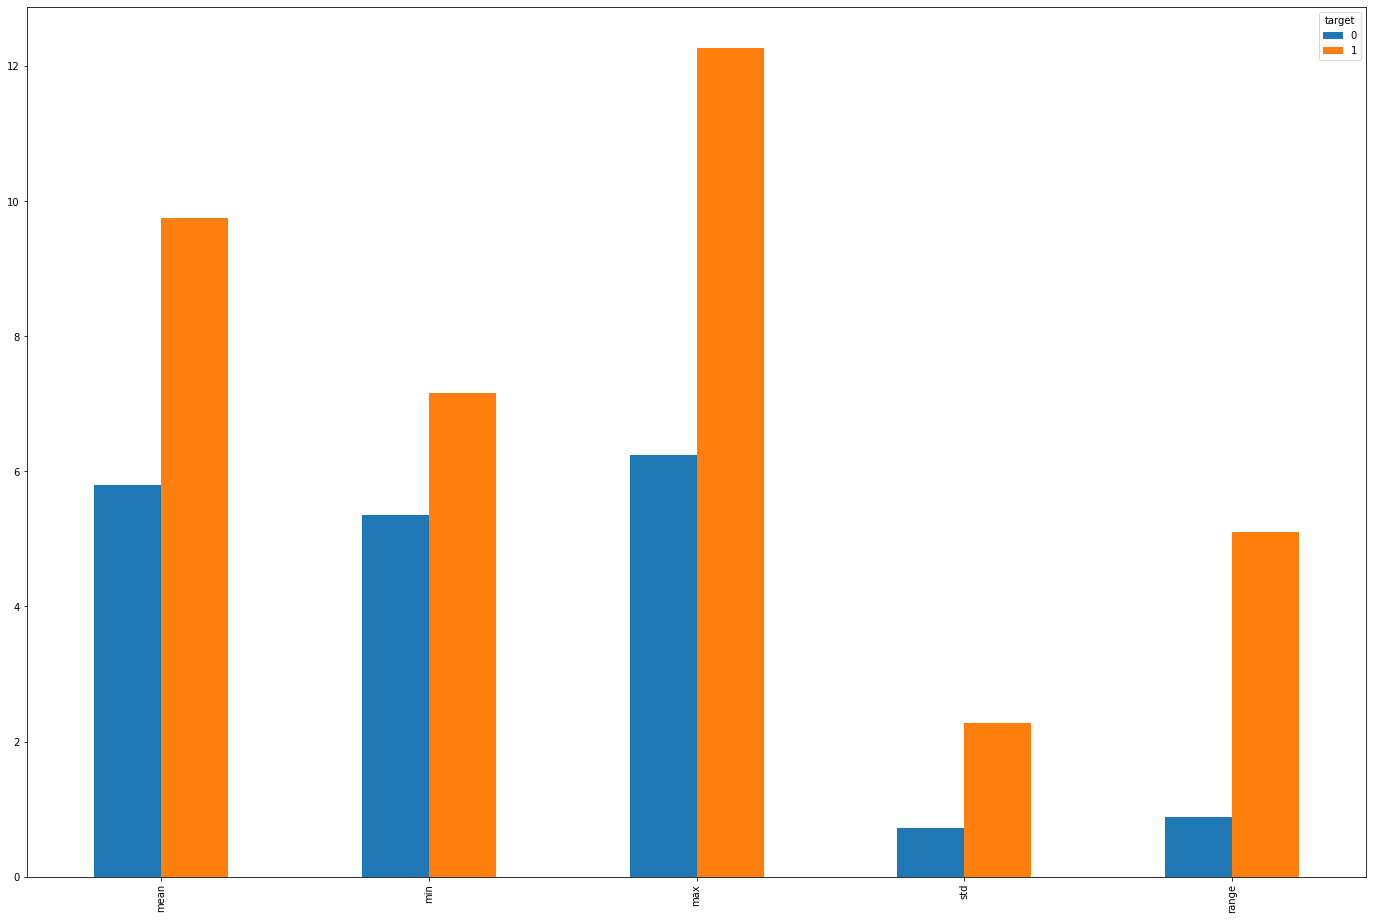

In [25]:
stat_df.groupby("target").mean().drop(columns=["day","subjectID"]).T.plot(kind="bar");

From the graph above it is clear that there is a big difference in the glucose levels of the two subsets.

## Train Test Split

In this section I will compare two models using the random forest algorithm:

1. Trained and tested using the 6 hour resampled data.
2. Trained and tested using with daily resampled data.

I am interested to see if there is a difference in accuracy

### 6 Hour Resampled Data

In [15]:
X1_train, y1_train, X1_test, y1_test  = train_test_split(stat_df)

X1_train["std"] = X1_train["std"].replace(np.nan, 0)
X1_test["std"] = X1_test["std"].replace(np.nan, 0)

In [16]:
print(f"The X_train set has {len(X1_train)} rows and {len(X1_train.columns)} features")
print(f"The X_train set has {len(X1_test)} rows and {len(X1_test.columns)} features")

The X_train set has 103 rows and 5 features
The X_train set has 43 rows and 5 features


In [29]:
# The model is trained using 5 fold cross validation
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X1_train, y1_train)

scores = cross_val_score(clf, X1_train, y1_train, cv=5)


C:\Users\PC\AppData\Local\Temp/ipykernel_13176/3075163417.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(X1_train, y1_train)
F:\PC\mambaforge\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\PC\mambaforge\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\PC\mambaforge\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

Accuracy score of 93.19%


In [30]:
print(f"Accuracy score of {(scores.mean()*100):.2f}%")

Accuracy score of 93.19%


### Daily Resampled Data

In [18]:
# Resample the data to daily
X = {}
for key in stat_dict:
    X[key] = []

numDays = 4
resample_period = "D"
day = [1,2,3,4]
for i, key in enumerate(glucose_dfs.keys()):
    df = glucose_dfs[key]
    df = fix_index(index_df.iloc[:-1], df)
    
    target = 1 if key.split("_")[0] == "diabetes" else 0
    find_stats(X, df, resample_period, target, numDays, i, day)


df = test_subject
df = fix_index(index_df.iloc[:-1], df)
find_stats(X, df, resample_period, 1, numDays,10, day)

for key in X:
    X[key] = np.array(X[key]).reshape(-1)

X["range"] = X["max"]-X["min"]    
    
X = pd.DataFrame(X)

In [19]:
X2_train, y2_train, X2_test, y2_test  = train_test_split(X)

In [20]:
print(f"The X_train set has {len(X2_train)} rows and {len(X2_train.columns)} features")
print(f"The X_train set has {len(X2_test)} rows and {len(X2_test.columns)} features")

The X_train set has 30 rows and 5 features
The X_train set has 14 rows and 5 features


In [ ]:
clf = RandomForestClassifier(random_state=0)
clf = clf.fit(X2_train, y2_train)

scores = cross_val_score(clf, X2_train, y2_train, cv=5)

In [21]:
print(f"Accuracy score of {(scores.mean()*100):.2f}%")

C:\Users\PC\AppData\Local\Temp/ipykernel_13176/2192283956.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(X2_train, y2_train)
F:\PC\mambaforge\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\PC\mambaforge\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
F:\PC\mambaforge\lib\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the sh

Accuracy score of 96.67%


### Results

The average cross validation accuracy score for the daily data is slightly higher than 6 hour data.  
I believe this is due to the fact that resampling the data to daily reduced the magnitude of noise in the data.

As you can see this also translated to classifying the test set.

In [22]:
# 6 hour resample
y1_hat = clf.predict(X1_test)
accuracy_score(y1_test, y1_hat)

0.813953488372093

In [23]:
# Daily resample
y2_hat = clf.predict(X2_test)
accuracy_score(y2_test, y2_hat)

0.9285714285714286